# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

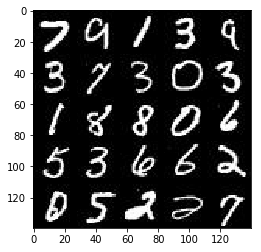

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

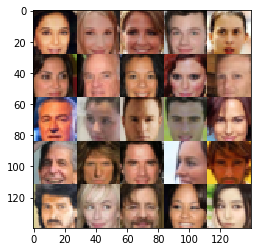

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name="real_input")
    z_input = tf.placeholder(tf.float32, [None, z_dim], name="z_input")
    lr = tf.placeholder(tf.float32, name="learning_rate")
    return real_input, z_input, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :param alpha: alpha for Leaky ReLU
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope("discriminator", reuse=reuse) as disc:
        kernel_init = tf.truncated_normal_initializer(stddev=0.1, dtype=tf.float32)
        conv1 = tf.layers.conv2d(images, filters=64, kernel_size=5, strides=2, padding="same",
                                 kernel_initializer=kernel_init)
        bn1 = tf.layers.batch_normalization(conv1, training=True)
        lrelu1 = tf.maximum(alpha * bn1, bn1)
        # now 14 x 14 x 64
        
        conv2 = tf.layers.conv2d(lrelu1, filters=128, kernel_size=5, strides=2, padding="same",
                                 kernel_initializer=kernel_init)
        bn2 = tf.layers.batch_normalization(conv2, training=True)
        lrelu2 = tf.maximum(alpha * bn2, bn2)
        # now 7 x 7 x 128
        
        conv3 = tf.layers.conv2d(lrelu2, filters=256, kernel_size=5, strides=2, padding="same",
                                 kernel_initializer=kernel_init)
        bn3 = tf.layers.batch_normalization(conv3, training=True)
        lrelu3 = tf.maximum(alpha * bn3, bn3)
        # now 4 x 4 x 256
        
        flat = tf.reshape(lrelu3, [-1, 4 * 4 * 256])
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :param alpha: alpha for Leaky ReLU
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope("generator", reuse=not is_train) as gen:
        kernel_init = tf.truncated_normal_initializer(stddev=0.1, dtype=tf.float32)
        dense1 = tf.layers.dense(z, 4 * 4 * 512)
        reshaped = tf.reshape(dense1, [-1, 4, 4, 512])
        reshaped = tf.layers.batch_normalization(reshaped, training=is_train)
        reshaped = tf.maximum(alpha * reshaped, reshaped)
        # now 4 x 4 x 512
        
        conv1 = tf.layers.conv2d_transpose(reshaped, filters=256, kernel_size=4, strides=1, padding="valid",
                                           kernel_initializer=kernel_init)
        bn1 = tf.layers.batch_normalization(conv1, training=is_train)
        lrelu1 = tf.maximum(alpha * bn1, bn1)
        # now 7 x 7 x 256
        
        conv2 = tf.layers.conv2d_transpose(lrelu1, filters=128, kernel_size=5, strides=2, padding="same",
                                           kernel_initializer=kernel_init)
        bn2 = tf.layers.batch_normalization(conv2, training=is_train)
        lrelu2 = tf.maximum(alpha * bn2, bn2)
        # now 14 x 14 x 128
        
        conv3 = tf.layers.conv2d_transpose(lrelu2, filters=64, kernel_size=5, strides=2, padding="same",
                                           kernel_initializer=kernel_init)
        bn3 = tf.layers.batch_normalization(conv3, training=is_train)
        lrelu3 = tf.maximum(alpha * bn3, bn3)
        # now 28 x 28 x 64

        # output layer, 28 x 28 x 3
        logits = tf.layers.conv2d_transpose(lrelu3, filters=out_channel_dim, kernel_size=1, strides=1, padding="same",
                                            kernel_initializer=kernel_init)
        out = tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, smooth=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    # TODO: Implement Function
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                                         labels=tf.ones_like(d_model_real * (1 - smooth))))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                         labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                    labels=tf.ones_like(d_model_fake)))
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [item for item in t_vars if item.name.startswith("discriminator")]
    g_vars = [item for item in t_vars if item.name.startswith("generator")]
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate,
                                             beta1=beta1).minimize(d_loss,
                                                                   var_list=d_vars) 
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate,
                                             beta1=beta1).minimize(g_loss,
                                                                   var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    real_inputs, z_inputs, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(real_inputs, z_inputs, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    with tf.Session() as sess:
        saver = tf.train.Saver()
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_images *= 2
                steps += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                _ = sess.run(d_opt, feed_dict={real_inputs:batch_images, z_inputs:batch_z})
                _ = sess.run(g_opt, feed_dict={real_inputs:batch_images, z_inputs:batch_z})
                
                if steps % 25 == 0:
                    train_loss_d = d_loss.eval({real_inputs:batch_images, z_inputs:batch_z})
                    train_loss_g = g_loss.eval({z_inputs:batch_z})

                    print("Epoch {}/{}...".format(epoch_i, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                if steps % 100 == 0:
                    show_generator_output(sess, 25, z_inputs, data_shape[3], data_image_mode)
        saver.save(sess, './checkpoints_dir/generator.ckpt')
    print("Finished training")

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 0/2... Discriminator Loss: 0.0535... Generator Loss: 7.2996
Epoch 0/2... Discriminator Loss: 1.1542... Generator Loss: 4.5843
Epoch 0/2... Discriminator Loss: 1.6110... Generator Loss: 2.2463
Epoch 0/2... Discriminator Loss: 2.1587... Generator Loss: 0.2200


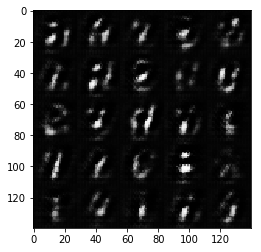

Epoch 0/2... Discriminator Loss: 1.6613... Generator Loss: 2.6203
Epoch 0/2... Discriminator Loss: 1.6415... Generator Loss: 0.3501
Epoch 0/2... Discriminator Loss: 1.3276... Generator Loss: 0.8351
Epoch 0/2... Discriminator Loss: 1.3497... Generator Loss: 1.7458


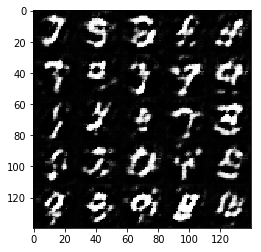

Epoch 0/2... Discriminator Loss: 1.4600... Generator Loss: 0.4284
Epoch 0/2... Discriminator Loss: 1.3894... Generator Loss: 0.5298
Epoch 0/2... Discriminator Loss: 1.3908... Generator Loss: 1.0036
Epoch 0/2... Discriminator Loss: 1.2136... Generator Loss: 1.2368


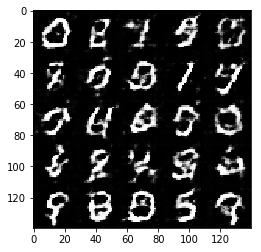

Epoch 0/2... Discriminator Loss: 1.4972... Generator Loss: 0.4069
Epoch 0/2... Discriminator Loss: 1.4843... Generator Loss: 0.3772
Epoch 0/2... Discriminator Loss: 1.3564... Generator Loss: 0.4839
Epoch 0/2... Discriminator Loss: 1.0349... Generator Loss: 0.9456


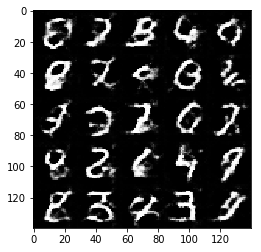

Epoch 0/2... Discriminator Loss: 1.4307... Generator Loss: 0.4355
Epoch 0/2... Discriminator Loss: 1.0621... Generator Loss: 0.7954
Epoch 0/2... Discriminator Loss: 1.4136... Generator Loss: 1.7115
Epoch 0/2... Discriminator Loss: 1.1252... Generator Loss: 0.6350


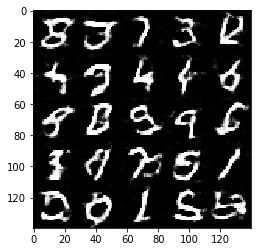

Epoch 0/2... Discriminator Loss: 1.1074... Generator Loss: 1.0129
Epoch 0/2... Discriminator Loss: 1.3315... Generator Loss: 0.6396
Epoch 0/2... Discriminator Loss: 1.2030... Generator Loss: 0.5887
Epoch 0/2... Discriminator Loss: 1.0969... Generator Loss: 0.7637


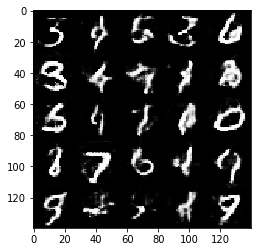

Epoch 0/2... Discriminator Loss: 1.4665... Generator Loss: 0.3689
Epoch 0/2... Discriminator Loss: 1.1994... Generator Loss: 0.5924
Epoch 0/2... Discriminator Loss: 1.6926... Generator Loss: 0.3337
Epoch 0/2... Discriminator Loss: 1.1212... Generator Loss: 0.6490


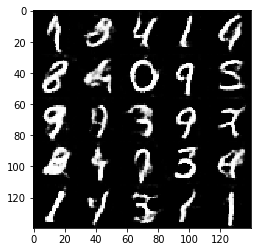

Epoch 0/2... Discriminator Loss: 0.8316... Generator Loss: 1.1260
Epoch 0/2... Discriminator Loss: 0.9782... Generator Loss: 1.0512
Epoch 0/2... Discriminator Loss: 1.2421... Generator Loss: 0.6083
Epoch 0/2... Discriminator Loss: 1.0989... Generator Loss: 0.7058


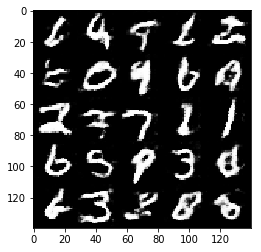

Epoch 0/2... Discriminator Loss: 1.3184... Generator Loss: 0.5098
Epoch 0/2... Discriminator Loss: 1.6626... Generator Loss: 0.2930
Epoch 0/2... Discriminator Loss: 1.6890... Generator Loss: 1.8666
Epoch 0/2... Discriminator Loss: 1.0161... Generator Loss: 0.9600


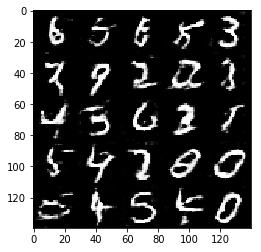

Epoch 0/2... Discriminator Loss: 1.2589... Generator Loss: 0.5772
Epoch 1/2... Discriminator Loss: 1.1089... Generator Loss: 0.9218
Epoch 1/2... Discriminator Loss: 1.3931... Generator Loss: 0.4456
Epoch 1/2... Discriminator Loss: 1.0575... Generator Loss: 0.6793


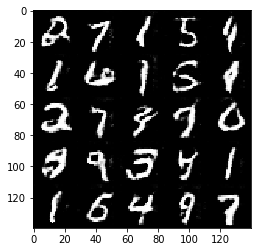

Epoch 1/2... Discriminator Loss: 1.6183... Generator Loss: 0.2964
Epoch 1/2... Discriminator Loss: 1.2419... Generator Loss: 0.8830
Epoch 1/2... Discriminator Loss: 0.9863... Generator Loss: 0.7399
Epoch 1/2... Discriminator Loss: 0.9521... Generator Loss: 1.2083


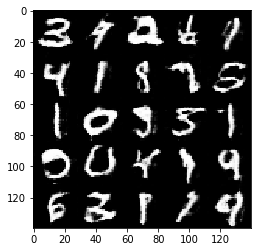

Epoch 1/2... Discriminator Loss: 1.1642... Generator Loss: 1.1482
Epoch 1/2... Discriminator Loss: 1.2092... Generator Loss: 0.8234
Epoch 1/2... Discriminator Loss: 0.9375... Generator Loss: 1.1286
Epoch 1/2... Discriminator Loss: 1.2688... Generator Loss: 1.4171


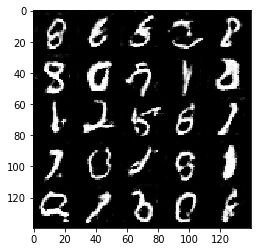

Epoch 1/2... Discriminator Loss: 1.4801... Generator Loss: 0.4185
Epoch 1/2... Discriminator Loss: 1.9107... Generator Loss: 0.2356
Epoch 1/2... Discriminator Loss: 1.0510... Generator Loss: 0.7686
Epoch 1/2... Discriminator Loss: 0.8339... Generator Loss: 0.9487


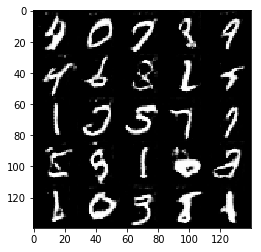

Epoch 1/2... Discriminator Loss: 1.7360... Generator Loss: 0.2738
Epoch 1/2... Discriminator Loss: 1.3086... Generator Loss: 0.5418
Epoch 1/2... Discriminator Loss: 1.5902... Generator Loss: 3.0766
Epoch 1/2... Discriminator Loss: 1.1866... Generator Loss: 1.6364


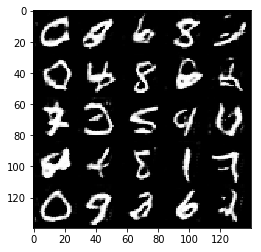

Epoch 1/2... Discriminator Loss: 0.8301... Generator Loss: 1.0097
Epoch 1/2... Discriminator Loss: 1.0083... Generator Loss: 1.2730
Epoch 1/2... Discriminator Loss: 0.9550... Generator Loss: 1.3782
Epoch 1/2... Discriminator Loss: 0.9915... Generator Loss: 1.1176


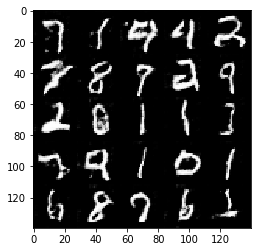

Epoch 1/2... Discriminator Loss: 1.3053... Generator Loss: 2.2560
Epoch 1/2... Discriminator Loss: 1.5132... Generator Loss: 0.3714
Epoch 1/2... Discriminator Loss: 1.0059... Generator Loss: 1.1991
Epoch 1/2... Discriminator Loss: 1.0345... Generator Loss: 1.8514


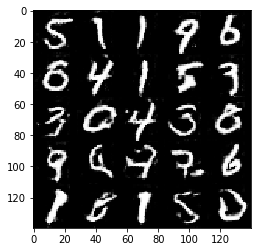

Epoch 1/2... Discriminator Loss: 1.2060... Generator Loss: 1.8859
Epoch 1/2... Discriminator Loss: 0.9257... Generator Loss: 1.3561
Epoch 1/2... Discriminator Loss: 2.0474... Generator Loss: 3.0269
Epoch 1/2... Discriminator Loss: 0.8925... Generator Loss: 0.7742


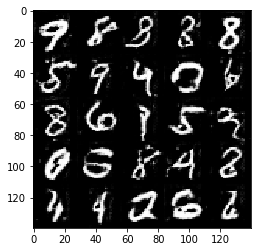

Epoch 1/2... Discriminator Loss: 1.5060... Generator Loss: 0.3914
Epoch 1/2... Discriminator Loss: 1.1857... Generator Loss: 0.5622
Epoch 1/2... Discriminator Loss: 0.6395... Generator Loss: 1.2879
Epoch 1/2... Discriminator Loss: 1.2230... Generator Loss: 0.5989


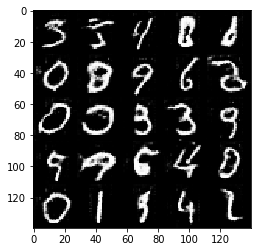

Epoch 1/2... Discriminator Loss: 1.0541... Generator Loss: 1.6960
Epoch 1/2... Discriminator Loss: 1.1700... Generator Loss: 0.5711
Finished training


In [12]:
batch_size = 64
z_dim = 200
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0/1... Discriminator Loss: 4.8466... Generator Loss: 0.0107
Epoch 0/1... Discriminator Loss: 0.9094... Generator Loss: 1.0984
Epoch 0/1... Discriminator Loss: 1.5813... Generator Loss: 2.3075
Epoch 0/1... Discriminator Loss: 1.8419... Generator Loss: 0.2742


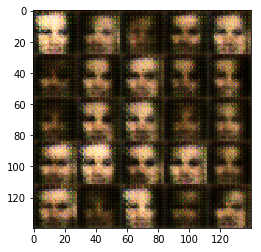

Epoch 0/1... Discriminator Loss: 2.0082... Generator Loss: 0.4468
Epoch 0/1... Discriminator Loss: 0.9572... Generator Loss: 1.7053
Epoch 0/1... Discriminator Loss: 1.4242... Generator Loss: 0.4947
Epoch 0/1... Discriminator Loss: 1.2935... Generator Loss: 1.1829


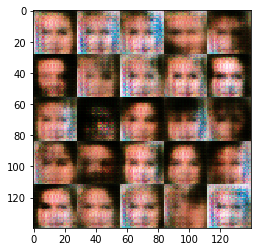

Epoch 0/1... Discriminator Loss: 2.1503... Generator Loss: 0.3199
Epoch 0/1... Discriminator Loss: 1.3940... Generator Loss: 1.2529
Epoch 0/1... Discriminator Loss: 2.1451... Generator Loss: 0.5232
Epoch 0/1... Discriminator Loss: 1.2676... Generator Loss: 0.7169


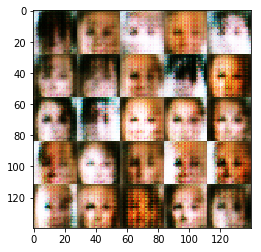

Epoch 0/1... Discriminator Loss: 1.2727... Generator Loss: 0.6689
Epoch 0/1... Discriminator Loss: 1.2818... Generator Loss: 0.8009
Epoch 0/1... Discriminator Loss: 1.3492... Generator Loss: 1.5457
Epoch 0/1... Discriminator Loss: 1.1449... Generator Loss: 0.7141


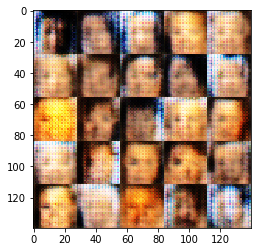

Epoch 0/1... Discriminator Loss: 1.1568... Generator Loss: 1.0209
Epoch 0/1... Discriminator Loss: 1.8149... Generator Loss: 0.3386
Epoch 0/1... Discriminator Loss: 1.4437... Generator Loss: 0.5832
Epoch 0/1... Discriminator Loss: 1.8666... Generator Loss: 2.4426


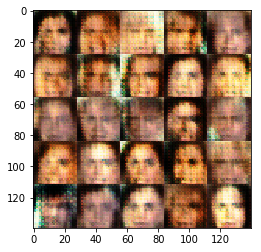

Epoch 0/1... Discriminator Loss: 1.6334... Generator Loss: 0.4383
Epoch 0/1... Discriminator Loss: 1.8795... Generator Loss: 0.2370
Epoch 0/1... Discriminator Loss: 1.4613... Generator Loss: 1.1999
Epoch 0/1... Discriminator Loss: 1.8459... Generator Loss: 0.2389


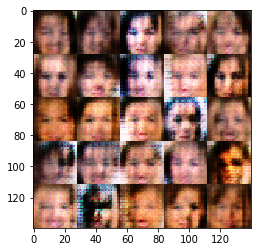

Epoch 0/1... Discriminator Loss: 1.3413... Generator Loss: 0.9238
Epoch 0/1... Discriminator Loss: 1.0239... Generator Loss: 0.8210
Epoch 0/1... Discriminator Loss: 1.3076... Generator Loss: 0.7022
Epoch 0/1... Discriminator Loss: 1.4134... Generator Loss: 0.7484


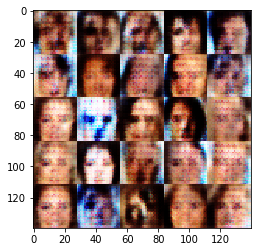

Epoch 0/1... Discriminator Loss: 1.6101... Generator Loss: 0.6692
Epoch 0/1... Discriminator Loss: 1.3814... Generator Loss: 0.9481
Epoch 0/1... Discriminator Loss: 1.1802... Generator Loss: 0.7778
Epoch 0/1... Discriminator Loss: 1.0463... Generator Loss: 0.7744


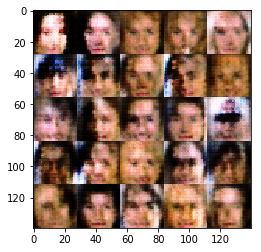

Epoch 0/1... Discriminator Loss: 1.7844... Generator Loss: 0.2659
Epoch 0/1... Discriminator Loss: 1.4673... Generator Loss: 0.5335
Epoch 0/1... Discriminator Loss: 1.3277... Generator Loss: 0.5504
Epoch 0/1... Discriminator Loss: 1.9634... Generator Loss: 0.4565


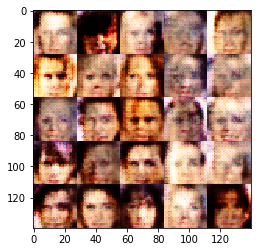

Epoch 0/1... Discriminator Loss: 1.6210... Generator Loss: 0.3622
Epoch 0/1... Discriminator Loss: 1.4958... Generator Loss: 0.4722
Epoch 0/1... Discriminator Loss: 1.3731... Generator Loss: 0.8796
Epoch 0/1... Discriminator Loss: 1.6623... Generator Loss: 0.6477


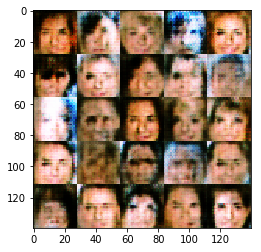

Epoch 0/1... Discriminator Loss: 1.0707... Generator Loss: 1.0058
Epoch 0/1... Discriminator Loss: 1.2402... Generator Loss: 1.4099
Epoch 0/1... Discriminator Loss: 1.2808... Generator Loss: 0.8044
Epoch 0/1... Discriminator Loss: 1.3483... Generator Loss: 0.5885


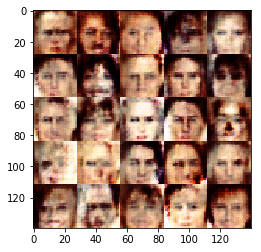

Epoch 0/1... Discriminator Loss: 1.2362... Generator Loss: 0.7154
Epoch 0/1... Discriminator Loss: 1.4764... Generator Loss: 0.4705
Epoch 0/1... Discriminator Loss: 1.3738... Generator Loss: 0.7959
Epoch 0/1... Discriminator Loss: 1.2295... Generator Loss: 0.7528


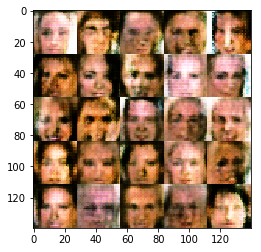

Epoch 0/1... Discriminator Loss: 1.4507... Generator Loss: 0.6175
Epoch 0/1... Discriminator Loss: 1.1870... Generator Loss: 0.6396
Epoch 0/1... Discriminator Loss: 1.3682... Generator Loss: 0.7444
Epoch 0/1... Discriminator Loss: 1.2282... Generator Loss: 1.1485


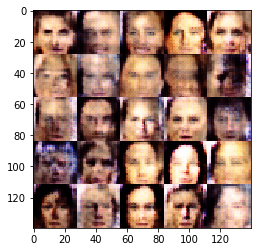

Epoch 0/1... Discriminator Loss: 1.7213... Generator Loss: 0.3883
Epoch 0/1... Discriminator Loss: 1.1396... Generator Loss: 1.0058
Epoch 0/1... Discriminator Loss: 1.3539... Generator Loss: 0.4391
Epoch 0/1... Discriminator Loss: 2.0287... Generator Loss: 0.1958


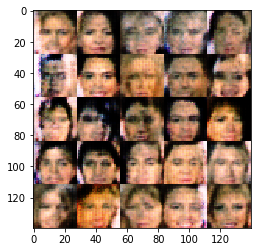

Epoch 0/1... Discriminator Loss: 1.1723... Generator Loss: 0.9937
Epoch 0/1... Discriminator Loss: 1.4445... Generator Loss: 0.4499
Epoch 0/1... Discriminator Loss: 1.4666... Generator Loss: 0.5081
Epoch 0/1... Discriminator Loss: 1.3893... Generator Loss: 0.5768


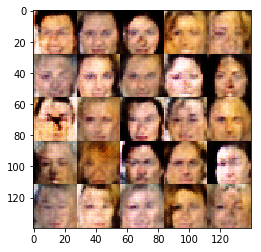

Epoch 0/1... Discriminator Loss: 1.4507... Generator Loss: 0.4965
Epoch 0/1... Discriminator Loss: 1.4611... Generator Loss: 0.6860
Epoch 0/1... Discriminator Loss: 1.4617... Generator Loss: 0.5007
Epoch 0/1... Discriminator Loss: 1.1979... Generator Loss: 0.7080


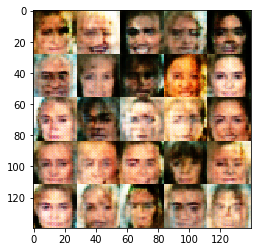

Epoch 0/1... Discriminator Loss: 1.2190... Generator Loss: 0.6690
Epoch 0/1... Discriminator Loss: 1.4326... Generator Loss: 0.4262
Epoch 0/1... Discriminator Loss: 1.2719... Generator Loss: 0.4265
Epoch 0/1... Discriminator Loss: 1.5925... Generator Loss: 0.4039


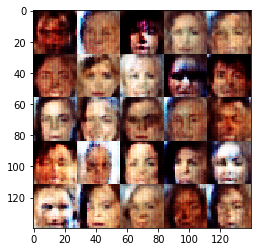

Epoch 0/1... Discriminator Loss: 1.6333... Generator Loss: 0.3143
Epoch 0/1... Discriminator Loss: 0.8788... Generator Loss: 1.1795
Epoch 0/1... Discriminator Loss: 1.5308... Generator Loss: 0.3924
Epoch 0/1... Discriminator Loss: 1.6984... Generator Loss: 0.3500


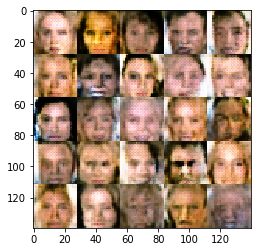

Epoch 0/1... Discriminator Loss: 1.7188... Generator Loss: 0.3186
Epoch 0/1... Discriminator Loss: 1.2767... Generator Loss: 0.5754
Epoch 0/1... Discriminator Loss: 1.0545... Generator Loss: 1.0294
Epoch 0/1... Discriminator Loss: 1.5493... Generator Loss: 0.3126


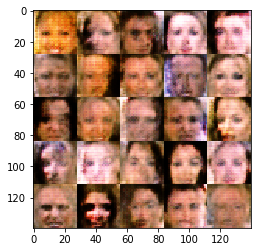

Epoch 0/1... Discriminator Loss: 1.4865... Generator Loss: 0.7467
Epoch 0/1... Discriminator Loss: 1.1187... Generator Loss: 1.0515
Epoch 0/1... Discriminator Loss: 1.0247... Generator Loss: 0.9717
Epoch 0/1... Discriminator Loss: 1.3953... Generator Loss: 0.4273


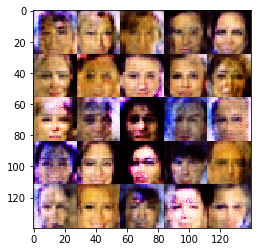

Epoch 0/1... Discriminator Loss: 1.6899... Generator Loss: 0.2823
Epoch 0/1... Discriminator Loss: 0.9325... Generator Loss: 0.9004
Epoch 0/1... Discriminator Loss: 1.3652... Generator Loss: 0.7058
Epoch 0/1... Discriminator Loss: 1.3156... Generator Loss: 1.2157


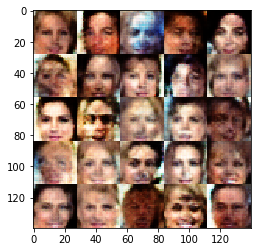

Epoch 0/1... Discriminator Loss: 1.2213... Generator Loss: 0.6209
Epoch 0/1... Discriminator Loss: 1.2525... Generator Loss: 1.0050
Epoch 0/1... Discriminator Loss: 1.2265... Generator Loss: 0.5606
Epoch 0/1... Discriminator Loss: 1.2668... Generator Loss: 0.9105


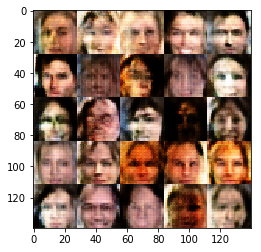

Epoch 0/1... Discriminator Loss: 1.3675... Generator Loss: 0.5298
Epoch 0/1... Discriminator Loss: 1.2619... Generator Loss: 0.5965
Epoch 0/1... Discriminator Loss: 1.2738... Generator Loss: 0.9801
Epoch 0/1... Discriminator Loss: 1.1692... Generator Loss: 0.7276


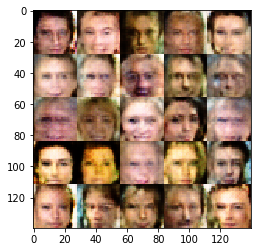

Epoch 0/1... Discriminator Loss: 1.5162... Generator Loss: 0.5542
Epoch 0/1... Discriminator Loss: 1.5089... Generator Loss: 0.4261
Epoch 0/1... Discriminator Loss: 1.3504... Generator Loss: 0.8629
Epoch 0/1... Discriminator Loss: 1.2253... Generator Loss: 0.5829


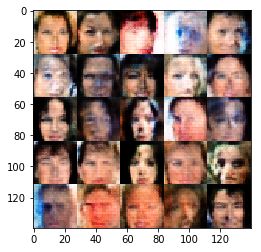

Epoch 0/1... Discriminator Loss: 1.2319... Generator Loss: 0.5947
Epoch 0/1... Discriminator Loss: 1.4532... Generator Loss: 0.5511
Epoch 0/1... Discriminator Loss: 1.4493... Generator Loss: 0.5536
Epoch 0/1... Discriminator Loss: 1.2732... Generator Loss: 0.6859


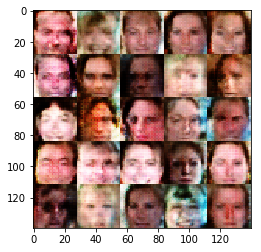

Epoch 0/1... Discriminator Loss: 1.4776... Generator Loss: 1.1993
Epoch 0/1... Discriminator Loss: 1.5644... Generator Loss: 0.4490
Epoch 0/1... Discriminator Loss: 1.4829... Generator Loss: 0.6557
Epoch 0/1... Discriminator Loss: 1.2760... Generator Loss: 0.6497


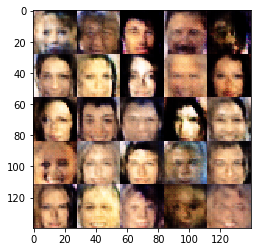

Epoch 0/1... Discriminator Loss: 1.4161... Generator Loss: 0.4833
Epoch 0/1... Discriminator Loss: 1.2566... Generator Loss: 0.5575
Epoch 0/1... Discriminator Loss: 1.5473... Generator Loss: 0.4889
Epoch 0/1... Discriminator Loss: 1.3309... Generator Loss: 0.6499


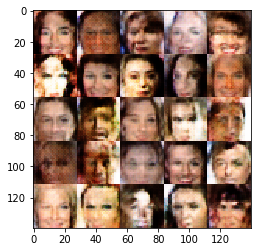

Epoch 0/1... Discriminator Loss: 1.7656... Generator Loss: 1.2593
Epoch 0/1... Discriminator Loss: 1.3763... Generator Loss: 0.6876
Epoch 0/1... Discriminator Loss: 1.3924... Generator Loss: 0.5523
Epoch 0/1... Discriminator Loss: 1.4171... Generator Loss: 0.6955


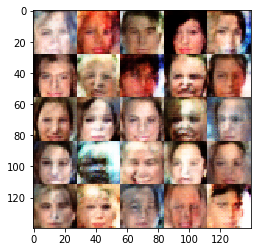

Epoch 0/1... Discriminator Loss: 1.3072... Generator Loss: 0.5981
Epoch 0/1... Discriminator Loss: 1.4506... Generator Loss: 0.5553
Epoch 0/1... Discriminator Loss: 1.4412... Generator Loss: 0.4801
Epoch 0/1... Discriminator Loss: 1.3175... Generator Loss: 0.5316


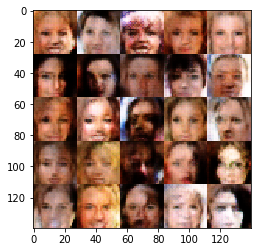

Epoch 0/1... Discriminator Loss: 1.3959... Generator Loss: 0.4739
Epoch 0/1... Discriminator Loss: 1.3430... Generator Loss: 0.6414
Epoch 0/1... Discriminator Loss: 1.5356... Generator Loss: 0.4116
Epoch 0/1... Discriminator Loss: 1.2436... Generator Loss: 0.5870


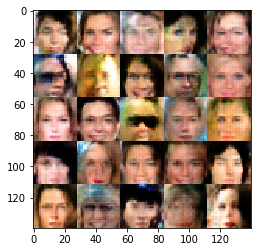

Epoch 0/1... Discriminator Loss: 1.3085... Generator Loss: 0.5032
Epoch 0/1... Discriminator Loss: 1.4026... Generator Loss: 0.6233
Epoch 0/1... Discriminator Loss: 1.2998... Generator Loss: 0.7480
Epoch 0/1... Discriminator Loss: 1.4566... Generator Loss: 0.4994


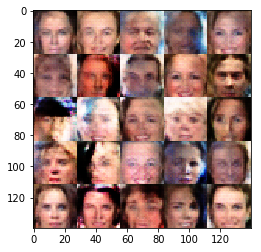

Epoch 0/1... Discriminator Loss: 1.5949... Generator Loss: 0.4035
Epoch 0/1... Discriminator Loss: 1.3779... Generator Loss: 0.6111
Epoch 0/1... Discriminator Loss: 1.3575... Generator Loss: 0.7169
Epoch 0/1... Discriminator Loss: 1.4749... Generator Loss: 0.4997


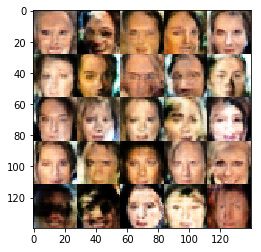

Epoch 0/1... Discriminator Loss: 1.4943... Generator Loss: 0.4679
Epoch 0/1... Discriminator Loss: 1.3039... Generator Loss: 0.5186
Epoch 0/1... Discriminator Loss: 1.3492... Generator Loss: 0.6821
Epoch 0/1... Discriminator Loss: 1.5276... Generator Loss: 0.4520


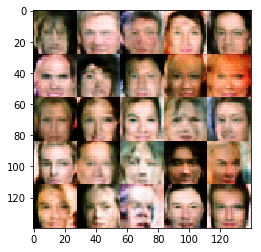

Epoch 0/1... Discriminator Loss: 1.3295... Generator Loss: 0.5190
Epoch 0/1... Discriminator Loss: 1.3898... Generator Loss: 1.0378
Epoch 0/1... Discriminator Loss: 1.5420... Generator Loss: 0.5382
Epoch 0/1... Discriminator Loss: 1.5207... Generator Loss: 0.4359


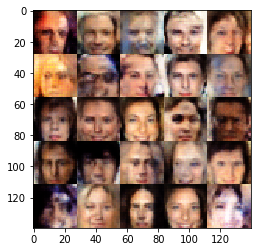

Epoch 0/1... Discriminator Loss: 1.2805... Generator Loss: 0.6089
Epoch 0/1... Discriminator Loss: 1.4338... Generator Loss: 0.5583
Epoch 0/1... Discriminator Loss: 1.5590... Generator Loss: 0.4406
Epoch 0/1... Discriminator Loss: 1.4173... Generator Loss: 0.9446


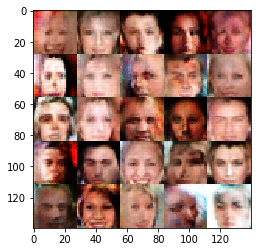

Epoch 0/1... Discriminator Loss: 1.3785... Generator Loss: 0.4636
Epoch 0/1... Discriminator Loss: 1.4868... Generator Loss: 0.4521
Epoch 0/1... Discriminator Loss: 1.3743... Generator Loss: 0.8157
Epoch 0/1... Discriminator Loss: 1.4005... Generator Loss: 0.4596


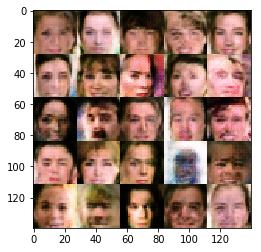

Epoch 0/1... Discriminator Loss: 1.2436... Generator Loss: 0.9726
Epoch 0/1... Discriminator Loss: 1.4858... Generator Loss: 0.6759
Epoch 0/1... Discriminator Loss: 1.5877... Generator Loss: 0.5556
Epoch 0/1... Discriminator Loss: 1.4207... Generator Loss: 0.5546


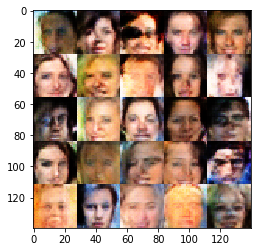

Epoch 0/1... Discriminator Loss: 1.5218... Generator Loss: 0.4453
Epoch 0/1... Discriminator Loss: 1.2438... Generator Loss: 0.6621
Epoch 0/1... Discriminator Loss: 1.4872... Generator Loss: 0.4809
Epoch 0/1... Discriminator Loss: 1.3790... Generator Loss: 0.6008


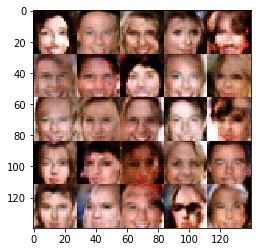

Epoch 0/1... Discriminator Loss: 1.4310... Generator Loss: 0.7908
Epoch 0/1... Discriminator Loss: 1.5032... Generator Loss: 0.4084
Epoch 0/1... Discriminator Loss: 1.3158... Generator Loss: 0.8924
Epoch 0/1... Discriminator Loss: 1.4757... Generator Loss: 0.6003


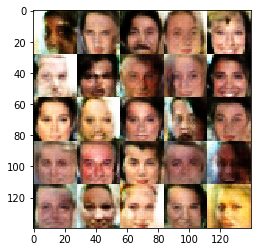

Epoch 0/1... Discriminator Loss: 1.3584... Generator Loss: 0.6609
Epoch 0/1... Discriminator Loss: 1.2287... Generator Loss: 0.5790
Epoch 0/1... Discriminator Loss: 1.4928... Generator Loss: 0.5163
Epoch 0/1... Discriminator Loss: 1.3881... Generator Loss: 0.5809


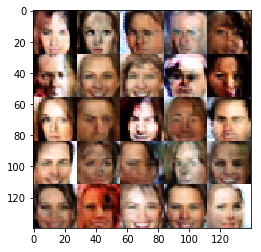

Epoch 0/1... Discriminator Loss: 1.4495... Generator Loss: 0.5261
Epoch 0/1... Discriminator Loss: 1.2348... Generator Loss: 0.7001
Epoch 0/1... Discriminator Loss: 1.4846... Generator Loss: 0.4000
Epoch 0/1... Discriminator Loss: 1.3494... Generator Loss: 0.7428


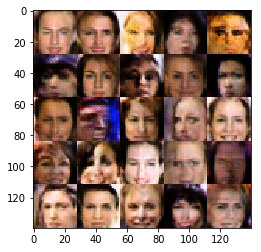

Epoch 0/1... Discriminator Loss: 1.3097... Generator Loss: 0.9183
Epoch 0/1... Discriminator Loss: 1.4153... Generator Loss: 0.4985
Epoch 0/1... Discriminator Loss: 1.3715... Generator Loss: 0.6862
Epoch 0/1... Discriminator Loss: 1.2967... Generator Loss: 0.8102


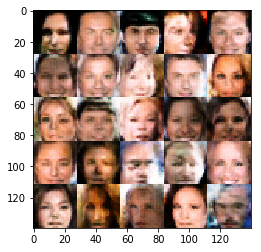

Epoch 0/1... Discriminator Loss: 1.4048... Generator Loss: 0.5811
Epoch 0/1... Discriminator Loss: 1.3999... Generator Loss: 0.5304
Epoch 0/1... Discriminator Loss: 1.7028... Generator Loss: 0.6109
Epoch 0/1... Discriminator Loss: 1.3971... Generator Loss: 0.5012


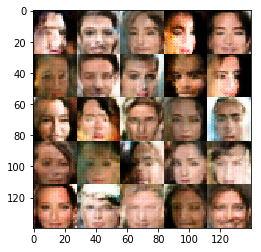

Epoch 0/1... Discriminator Loss: 1.3612... Generator Loss: 0.5032
Epoch 0/1... Discriminator Loss: 1.6035... Generator Loss: 0.4375
Epoch 0/1... Discriminator Loss: 1.1117... Generator Loss: 0.7806
Epoch 0/1... Discriminator Loss: 1.5838... Generator Loss: 0.3839


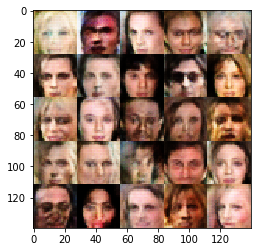

Epoch 0/1... Discriminator Loss: 1.3437... Generator Loss: 0.5819
Epoch 0/1... Discriminator Loss: 1.3848... Generator Loss: 0.4568
Epoch 0/1... Discriminator Loss: 1.3717... Generator Loss: 0.5187
Epoch 0/1... Discriminator Loss: 1.4497... Generator Loss: 0.6579


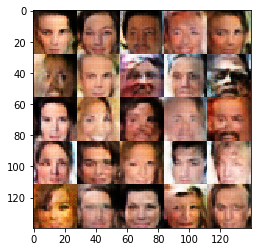

Epoch 0/1... Discriminator Loss: 1.3317... Generator Loss: 0.6711
Epoch 0/1... Discriminator Loss: 1.2910... Generator Loss: 0.6198
Epoch 0/1... Discriminator Loss: 1.5254... Generator Loss: 0.4287
Epoch 0/1... Discriminator Loss: 1.4978... Generator Loss: 0.6066


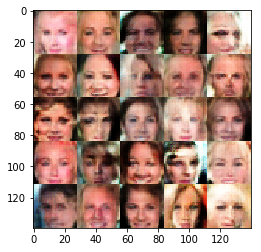

Epoch 0/1... Discriminator Loss: 1.2881... Generator Loss: 0.7135
Epoch 0/1... Discriminator Loss: 1.3843... Generator Loss: 0.6555
Epoch 0/1... Discriminator Loss: 1.4004... Generator Loss: 0.5793
Epoch 0/1... Discriminator Loss: 1.2710... Generator Loss: 0.6916


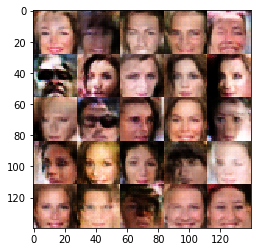

Epoch 0/1... Discriminator Loss: 1.3803... Generator Loss: 0.7343
Epoch 0/1... Discriminator Loss: 1.4306... Generator Loss: 0.6910
Epoch 0/1... Discriminator Loss: 1.4036... Generator Loss: 0.5888
Epoch 0/1... Discriminator Loss: 1.3858... Generator Loss: 0.6326


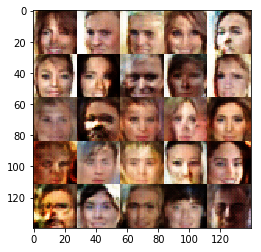

Epoch 0/1... Discriminator Loss: 1.5536... Generator Loss: 0.4830
Epoch 0/1... Discriminator Loss: 1.3117... Generator Loss: 0.5868
Epoch 0/1... Discriminator Loss: 1.3181... Generator Loss: 0.7835
Epoch 0/1... Discriminator Loss: 1.4932... Generator Loss: 0.5660


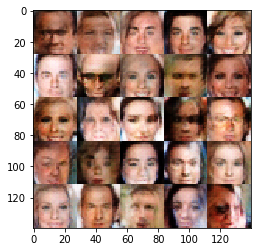

Epoch 0/1... Discriminator Loss: 1.4548... Generator Loss: 0.4824
Epoch 0/1... Discriminator Loss: 1.6551... Generator Loss: 0.5780
Epoch 0/1... Discriminator Loss: 1.6707... Generator Loss: 0.4488
Epoch 0/1... Discriminator Loss: 1.3637... Generator Loss: 0.7730


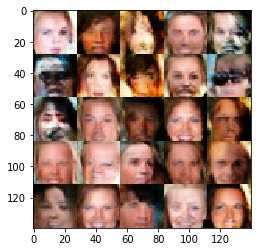

Epoch 0/1... Discriminator Loss: 1.2255... Generator Loss: 0.7782
Epoch 0/1... Discriminator Loss: 1.4067... Generator Loss: 0.6010
Epoch 0/1... Discriminator Loss: 1.4183... Generator Loss: 0.4887
Epoch 0/1... Discriminator Loss: 1.5842... Generator Loss: 0.6947


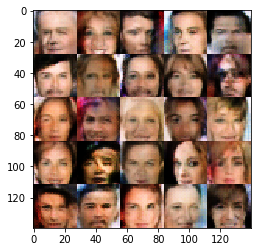

Epoch 0/1... Discriminator Loss: 1.3073... Generator Loss: 0.6284
Epoch 0/1... Discriminator Loss: 1.3448... Generator Loss: 0.6458
Epoch 0/1... Discriminator Loss: 1.3592... Generator Loss: 0.6385
Epoch 0/1... Discriminator Loss: 1.4038... Generator Loss: 0.7387


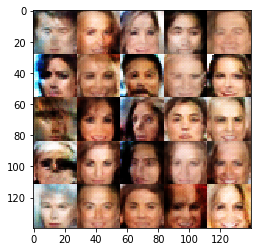

Epoch 0/1... Discriminator Loss: 1.1628... Generator Loss: 0.6873
Epoch 0/1... Discriminator Loss: 1.7844... Generator Loss: 0.3796
Epoch 0/1... Discriminator Loss: 1.4783... Generator Loss: 0.5726
Epoch 0/1... Discriminator Loss: 1.4690... Generator Loss: 0.5704


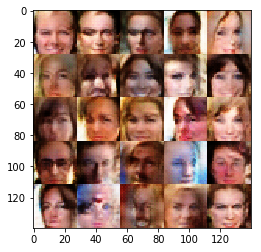

Epoch 0/1... Discriminator Loss: 1.4345... Generator Loss: 0.5496
Epoch 0/1... Discriminator Loss: 1.3471... Generator Loss: 0.6029
Epoch 0/1... Discriminator Loss: 1.6063... Generator Loss: 0.3718
Epoch 0/1... Discriminator Loss: 1.4423... Generator Loss: 0.5137


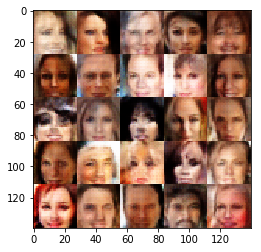

Epoch 0/1... Discriminator Loss: 1.2186... Generator Loss: 0.7503
Epoch 0/1... Discriminator Loss: 1.5581... Generator Loss: 0.6254
Epoch 0/1... Discriminator Loss: 1.4093... Generator Loss: 0.6342
Epoch 0/1... Discriminator Loss: 1.2491... Generator Loss: 0.6447


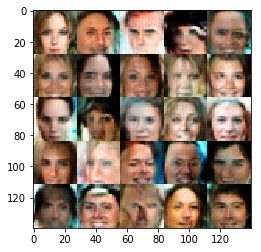

Epoch 0/1... Discriminator Loss: 1.1944... Generator Loss: 0.6494
Epoch 0/1... Discriminator Loss: 1.5162... Generator Loss: 0.6681
Epoch 0/1... Discriminator Loss: 1.3295... Generator Loss: 0.5694
Epoch 0/1... Discriminator Loss: 1.2466... Generator Loss: 0.6513


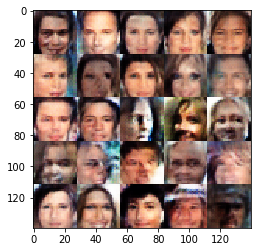

Epoch 0/1... Discriminator Loss: 1.3475... Generator Loss: 0.5908
Epoch 0/1... Discriminator Loss: 1.5795... Generator Loss: 0.3951
Epoch 0/1... Discriminator Loss: 1.3677... Generator Loss: 0.5565
Epoch 0/1... Discriminator Loss: 1.5863... Generator Loss: 0.4577


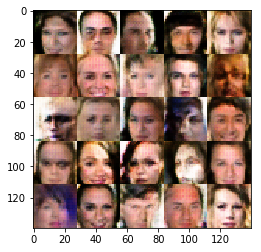

Epoch 0/1... Discriminator Loss: 1.2029... Generator Loss: 0.7642
Epoch 0/1... Discriminator Loss: 1.3130... Generator Loss: 0.7508
Epoch 0/1... Discriminator Loss: 1.3267... Generator Loss: 0.5623
Epoch 0/1... Discriminator Loss: 1.3622... Generator Loss: 0.5303


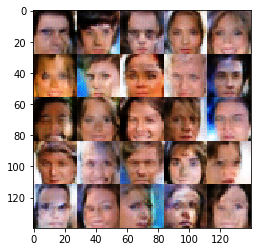

Epoch 0/1... Discriminator Loss: 1.3846... Generator Loss: 0.6722
Epoch 0/1... Discriminator Loss: 1.4410... Generator Loss: 0.6150
Epoch 0/1... Discriminator Loss: 1.3229... Generator Loss: 0.7550
Epoch 0/1... Discriminator Loss: 1.3633... Generator Loss: 0.6791


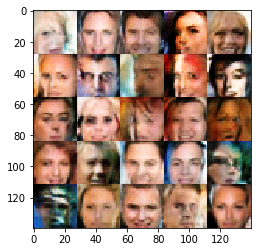

Epoch 0/1... Discriminator Loss: 1.2588... Generator Loss: 0.5651
Epoch 0/1... Discriminator Loss: 1.3960... Generator Loss: 0.7202
Epoch 0/1... Discriminator Loss: 1.2863... Generator Loss: 0.5447
Epoch 0/1... Discriminator Loss: 1.2364... Generator Loss: 0.7277


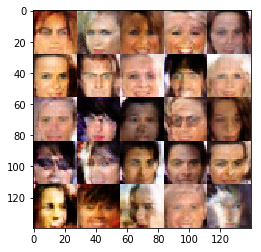

Epoch 0/1... Discriminator Loss: 1.3477... Generator Loss: 0.6313
Epoch 0/1... Discriminator Loss: 1.4403... Generator Loss: 0.5751
Epoch 0/1... Discriminator Loss: 1.4841... Generator Loss: 0.6809
Epoch 0/1... Discriminator Loss: 1.3299... Generator Loss: 0.7219


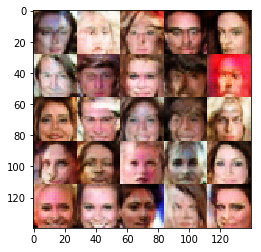

Epoch 0/1... Discriminator Loss: 1.3707... Generator Loss: 0.5367
Epoch 0/1... Discriminator Loss: 1.4969... Generator Loss: 0.4987
Epoch 0/1... Discriminator Loss: 1.2937... Generator Loss: 0.7189
Epoch 0/1... Discriminator Loss: 1.3985... Generator Loss: 0.5719


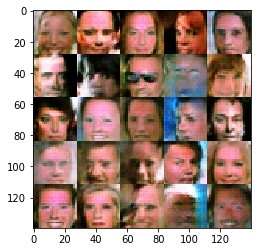

Epoch 0/1... Discriminator Loss: 1.2993... Generator Loss: 0.7302
Epoch 0/1... Discriminator Loss: 1.6489... Generator Loss: 0.3494
Epoch 0/1... Discriminator Loss: 1.2154... Generator Loss: 0.7295
Epoch 0/1... Discriminator Loss: 1.4621... Generator Loss: 0.4770


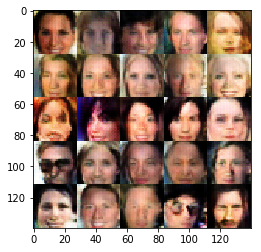

Epoch 0/1... Discriminator Loss: 1.4197... Generator Loss: 0.4912
Finished training


In [13]:
batch_size = 32
z_dim = 200
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.